In [11]:
import torch
import inspect
import torch.optim as optim
import torch.utils.data
import torch.nn
import torch.nn.functional as F
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [106]:
class GeneratorNet(torch.nn.Module):
    def __init__(self):
        super(GeneratorNet, self).__init__()
        self.fc1 = torch.nn.Linear(1, 64)
        self.fc2 = torch.nn.Linear(64, 64)
        self.fc3 = torch.nn.Linear(64, 64)
        self.fc4 = torch.nn.Linear(64, 64)
        self.fc5 = torch.nn.Linear(64, 1)

    def forward(self, x):
        x = F.softplus(self.fc1(x))
        x = F.softplus(self.fc2(x))
        x = F.softplus(self.fc3(x))
        x = F.softplus(self.fc4(x))
        x = self.fc5(x)
        return x

gnet = GeneratorNet()

In [85]:
def generator(z, parameters): 
    """
    Runs forward propagation on z and parameters.
    
    Arguments:
    z -- noise
    parameters -- neural net weights
    
    Returns:
    z -- output of last activation layer
    """
    z = z.t()
    z = parameters['W1'] @ z + parameters['b1']
    z = F.softplus(z)
    z = parameters['W2'] @ z + parameters['b2']
    z = F.softplus(z)
    z = parameters['W3'] @ z + parameters['b3']
    z = F.softplus(z)
    z = parameters['W4'] @ z + parameters['b4']
    z = F.tanh(z)
    return z.t()

In [86]:
X = torch.sort(torch.Tensor(16384, 1).uniform_(-1, 1), dim=0)[0]
Y = torch.sort(torch.Tensor(16384, 1).normal_(), dim=0)[0]
# Y = torch.sort(torch.Tensor(16384, 1).uniform_(2, 3), dim=0)[0]
dataset = torch.utils.data.TensorDataset(X, Y, )
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
parameters = {'W1': torch.nn.init.xavier_uniform_(torch.zeros((64,1), requires_grad=True)),
              'b1': torch.nn.init.xavier_uniform_(torch.zeros((64, 1), requires_grad=True)),
'W2': torch.nn.init.xavier_uniform_(torch.zeros((64,64), requires_grad=True)),
              'b2': torch.nn.init.xavier_uniform_(torch.zeros((64, 1), requires_grad=True)),
              'W3': torch.nn.init.xavier_uniform_(torch.zeros((64,64), requires_grad=True)),
              'b3': torch.nn.init.xavier_uniform_(torch.zeros((64, 1), requires_grad=True)),
    'W4': torch.nn.init.xavier_uniform_(torch.zeros((1, 64),requires_grad=True)),
              'b4': torch.nn.init.xavier_uniform_(torch.zeros((1, 1), requires_grad=True)),
}
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(list(parameters.values()))

In [107]:
batch_mod = 100
epoch_mod = 10
for epoch in range(50):
    running_loss = 0.0
    optimizer.zero_grad() # Why...
    for batch_idx, data in enumerate(dataloader):
        inputs, labels = data
#         outputs = generator(inputs, parameters)
        outputs = gnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if (batch_idx % batch_mod == 0 and batch_idx > 0 and epoch % epoch_mod == 0):
            print(F"Epoch: {epoch}, Batch: {batch_idx}, Loss: {running_loss/modulus}")
            running_loss = 0.0

Epoch: 0, Batch: 100, Loss: 1.1509834662079812
Epoch: 0, Batch: 200, Loss: 1.1078091323375703
Epoch: 0, Batch: 300, Loss: 1.07460867613554
Epoch: 0, Batch: 400, Loss: 1.1199711805582047
Epoch: 0, Batch: 500, Loss: 1.1078906762599945
Epoch: 10, Batch: 100, Loss: 1.1022065365314484
Epoch: 10, Batch: 200, Loss: 1.1017107605934142
Epoch: 10, Batch: 300, Loss: 1.113297313451767
Epoch: 10, Batch: 400, Loss: 1.1180384689569474
Epoch: 10, Batch: 500, Loss: 1.1358417302370072
Epoch: 20, Batch: 100, Loss: 1.1335555094480514
Epoch: 20, Batch: 200, Loss: 1.1145295313000678
Epoch: 20, Batch: 300, Loss: 1.1103493690490722
Epoch: 20, Batch: 400, Loss: 1.1189341965317725
Epoch: 20, Batch: 500, Loss: 1.0890692949295044
Epoch: 30, Batch: 100, Loss: 1.114173310995102
Epoch: 30, Batch: 200, Loss: 1.0900609982013703
Epoch: 30, Batch: 300, Loss: 1.1527364820241928
Epoch: 30, Batch: 400, Loss: 1.1026414829492568
Epoch: 30, Batch: 500, Loss: 1.1068765830993652
Epoch: 40, Batch: 100, Loss: 1.1778959810733796
E

/Users/richard/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


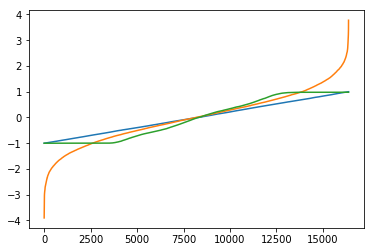

In [105]:
plot(X.numpy())
plot(Y.numpy())
plot(generator(X, parameters).data.numpy())

In [ ]:
def discriminator(x, theta_d): 
    #x:=input sample
    #theta_d:=neural net params
    #Returns scalar probability that x comes from data rather than generator

In [14]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 6, 5)
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.conv2 = torch.nn.Conv2d(6, 16, 5)
        self.fc1 = torch.nn.Linear(16 * 5 * 5, 120)
        self.fc2 = torch.nn.Linear(120, 84)
        self.fc3 = torch.nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [25]:
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)